# Feature Set Comparison

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import shap

/Users/shainedl/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shainedl/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shainedl/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/shainedl/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

## Read in and Split Data

In [3]:
# read in data
data = pd.read_csv('../data/hospitalization_data.csv', dtype={'FIPS': object})
data.head()

,FIPS,Hospitalizations,Cases,State,County,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Hospitalization Rate,Case Rate,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,12041,80,1588,Florida,Gilchrist,8968.375038,21.126757,4.763684,4.847069,7.669173,...,9.381368,3.4,52.053416,7.608085,52.605415,13.496566,438.2,8698.5,0,1521
1,12107,566,6374,Florida,Putnam,12710.036010,24.952601,5.359802,4.937745,10.439560,...,7.827534,4.3,55.123245,10.481016,52.040792,10.449204,763.2,8594.6,1,1766
2,12123,97,2710,Florida,Taylor,10593.946360,23.831961,4.855759,4.745002,9.772588,...,5.633540,3.6,54.561016,9.412498,60.553383,6.022409,448.6,12533.0,1,1201
3,12091,729,20298,Florida,Okaloosa,8033.687940,15.266246,3.889858,3.875538,7.872828,...,19.608361,2.7,40.581558,17.700785,39.062417,11.659616,351.7,9793.1,0,836
4,12013,59,1686,Florida,Calhoun,10649.098250,24.278851,4.887984,4.772105,8.024691,...,7.022045,4.1,58.913803,8.432470,56.585692,11.858775,404.5,11558.2,0,1621


In [4]:
X = data.drop(["FIPS", "Hospitalizations", "Cases", "Hospitalization Rate", "State", "County"], axis=1)
y = pd.DataFrame(data["Hospitalization Rate"])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
len(X.columns)

97

## Dummy Baseline

In [8]:
y_train_mean = y_train.mean()
y_train_mean

Hospitalization Rate    469.481548
dtype: float64

In [9]:
(((y_test - y_train_mean)**2).sum())**(.5)

Hospitalization Rate    2358.620794
dtype: float64

## MLP: XGBoost Most Important Features

In [10]:
X_train_x = X_train.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '% Diagnosed Diabetes'])

X_val_x = X_val.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '% Diagnosed Diabetes'])

X_test_x = X_test.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '% Diagnosed Diabetes'])

In [8]:
"""
Loading custom dataset into Tensors
https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
"""
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.tensor(X.values).float()
        if not torch.is_tensor(y):
            self.y = torch.tensor(y.values).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
train_data_x = PrepareData(X_train_x, y_train)
val_data_x = PrepareData(X_val_x, y_val)
test_data_x = PrepareData(X_test_x, y_test)

In [9]:
batch_size = 8

In [14]:
train_loader_x = DataLoader(train_data_x, 
                          batch_size)

valid_loader_x = DataLoader(val_data_x, 
                          batch_size)

test_loader_x = DataLoader(test_data_x, 
                         batch_size)

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim=8, output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 6)
        self.fc2 = nn.Linear(6, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, output_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Input
        -----
        x: tensor (batch size x important variable size)
        
        Output
        ------
        predicted values of Hosp rate
            tensor(batch size x 1)
        """
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        
        x = self.fc4(x)
        return x

In [97]:
mlp = MLP(input_dim=7)
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [98]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_x:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_x:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_xgb.model')

Epoch: 1 	Training Loss: 412.267135 	Validation Loss: 305.293259
Epoch: 2 	Training Loss: 305.204030 	Validation Loss: 247.004542
Epoch: 3 	Training Loss: 297.119396 	Validation Loss: 253.916331
Epoch: 4 	Training Loss: 306.362967 	Validation Loss: 251.280846
Epoch: 5 	Training Loss: 303.076643 	Validation Loss: 257.789115
Epoch: 6 	Training Loss: 291.612424 	Validation Loss: 251.659610
Epoch: 7 	Training Loss: 299.260428 	Validation Loss: 254.161846
Epoch: 8 	Training Loss: 302.576602 	Validation Loss: 249.779200
Epoch: 9 	Training Loss: 295.510963 	Validation Loss: 251.891221
Epoch: 10 	Training Loss: 291.745759 	Validation Loss: 251.812825
Epoch: 11 	Training Loss: 283.359082 	Validation Loss: 247.818891
Epoch: 12 	Training Loss: 289.955933 	Validation Loss: 250.679728
Epoch: 13 	Training Loss: 294.852292 	Validation Loss: 257.616978
Epoch: 14 	Training Loss: 292.934814 	Validation Loss: 251.265490
Epoch: 15 	Training Loss: 286.423007 	Validation Loss: 249.072404
Epoch: 16 	Training

In [99]:
best_val_loss

168.55573272705078

In [100]:
mlp.load_state_dict(torch.load('mlp_xgb.model'))

In [101]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_x:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_x)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 183.056675



### Explain output through SHAP

In [102]:
mlp = MLP(input_dim=7)
mlp.load_state_dict(torch.load('mlp_xgb.model'))

In [103]:
x_x, _ = next(iter(train_loader_x))

In [104]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_x)

shap_values = explainer_shap.shap_values(X=x_x,
                                      ranked_outputs=True)

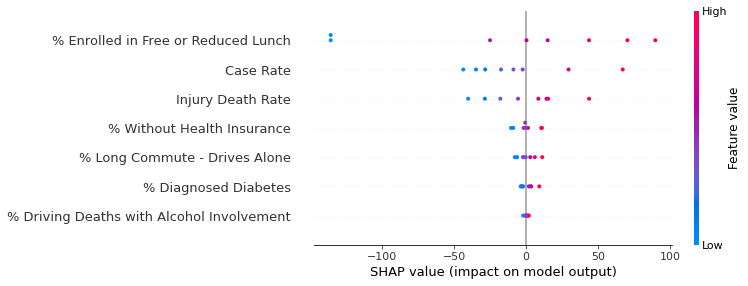

In [105]:
shap.summary_plot(shap_values, x_x, feature_names=X_train_x.columns)

### Replace % Diagnosed Diabetes with % Adults with Obesity

In [35]:
X_train_x2 = X_train.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '%  Adults with Obesity'])

X_val_x2 = X_val.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '%  Adults with Obesity'])

X_test_x2 = X_test.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '%  Adults with Obesity'])

In [36]:
train_data_x2 = PrepareData(X_train_x2, y_train)
val_data_x2 = PrepareData(X_val_x2, y_val)
test_data_x2 = PrepareData(X_test_x2, y_test)

In [37]:
train_loader_x2 = DataLoader(train_data_x2, 
                          batch_size)

valid_loader_x2 = DataLoader(val_data_x2, 
                          batch_size)

test_loader_x2 = DataLoader(test_data_x2, 
                         batch_size)

In [68]:
mlp = MLP(input_dim=7)
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [69]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_x2:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_x2:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_xgb2.model')

Epoch: 1 	Training Loss: 401.139912 	Validation Loss: 313.234489
Epoch: 2 	Training Loss: 321.934670 	Validation Loss: 254.275292
Epoch: 3 	Training Loss: 311.774242 	Validation Loss: 261.322334
Epoch: 4 	Training Loss: 309.027839 	Validation Loss: 255.715225
Epoch: 5 	Training Loss: 311.793623 	Validation Loss: 254.075777
Epoch: 6 	Training Loss: 292.550139 	Validation Loss: 250.018201
Epoch: 7 	Training Loss: 302.933239 	Validation Loss: 249.728029
Epoch: 8 	Training Loss: 312.227292 	Validation Loss: 256.274126
Epoch: 9 	Training Loss: 296.531701 	Validation Loss: 248.951466
Epoch: 10 	Training Loss: 310.122192 	Validation Loss: 254.586064
Epoch: 11 	Training Loss: 300.609032 	Validation Loss: 250.210864
Epoch: 12 	Training Loss: 304.827816 	Validation Loss: 250.048612
Epoch: 13 	Training Loss: 313.361902 	Validation Loss: 255.034651
Epoch: 14 	Training Loss: 289.775260 	Validation Loss: 250.744653
Epoch: 15 	Training Loss: 294.853913 	Validation Loss: 252.458276
Epoch: 16 	Training

In [70]:
best_val_loss

176.0746674971147

In [71]:
mlp.load_state_dict(torch.load('mlp_xgb2.model'))

In [72]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_x2:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_x2)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 186.807463



In [73]:
mlp = MLP(input_dim=7)
mlp.load_state_dict(torch.load('mlp_xgb2.model'))

In [74]:
x_x2, _ = next(iter(train_loader_x2))

In [75]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_x2)

shap_values = explainer_shap.shap_values(X=x_x2,
                                      ranked_outputs=True)

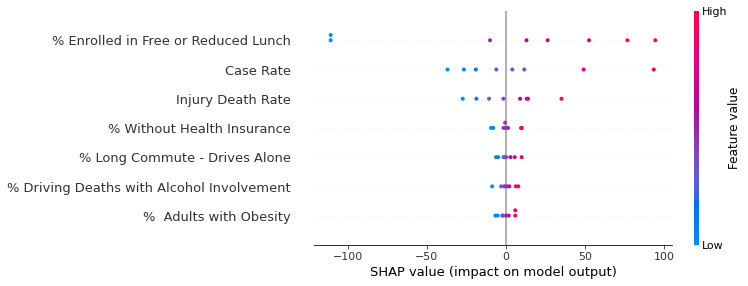

In [76]:
shap.summary_plot(shap_values, x_x2, feature_names=X_train_x.columns)

## MLP: Original Features

In [106]:
X_train_o = X_train.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers'])

X_val_o = X_val.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers'])

X_test_o = X_test.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers'])

In [107]:
train_data_o = PrepareData(X_train_o, y_train)
val_data_o = PrepareData(X_val_o, y_val)
test_data_o = PrepareData(X_test_o, y_test)

In [108]:
train_loader_o = DataLoader(train_data_o, 
                          batch_size)

valid_loader_o = DataLoader(val_data_o, 
                          batch_size)

test_loader_o = DataLoader(test_data_o, 
                         batch_size)

In [113]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [114]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_o:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_o:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_org.model')

Epoch: 1 	Training Loss: 524.235002 	Validation Loss: 546.542677
Epoch: 2 	Training Loss: 517.357788 	Validation Loss: 530.599582
Epoch: 3 	Training Loss: 493.237394 	Validation Loss: 546.701019
Epoch: 4 	Training Loss: 461.319806 	Validation Loss: 534.752819
Epoch: 5 	Training Loss: 417.657151 	Validation Loss: 529.216958
Epoch: 6 	Training Loss: 392.659350 	Validation Loss: 466.660258
Epoch: 7 	Training Loss: 348.484773 	Validation Loss: 410.573765
Epoch: 8 	Training Loss: 315.731344 	Validation Loss: 348.204014
Epoch: 9 	Training Loss: 284.887996 	Validation Loss: 297.860386
Epoch: 10 	Training Loss: 293.577394 	Validation Loss: 276.860514
Epoch: 11 	Training Loss: 284.216035 	Validation Loss: 266.744540
Epoch: 12 	Training Loss: 275.412076 	Validation Loss: 266.152602
Epoch: 13 	Training Loss: 282.899286 	Validation Loss: 259.088167
Epoch: 14 	Training Loss: 266.903132 	Validation Loss: 262.587261
Epoch: 15 	Training Loss: 290.766014 	Validation Loss: 262.404400
Epoch: 16 	Training

In [115]:
best_val_loss

235.88265228271484

In [116]:
mlp.load_state_dict(torch.load('mlp_org.model'))

In [117]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_o:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_o)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 228.285036



### Explain output through SHAP

In [60]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_org.model'))

In [61]:
x_o, _ = next(iter(train_loader_o))

In [62]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_o)

shap_values = explainer_shap.shap_values(X=x_o,
                                      ranked_outputs=True)

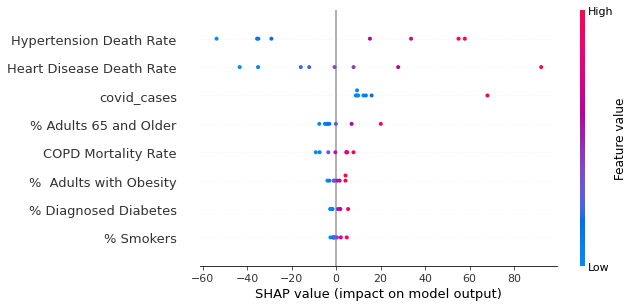

In [63]:
shap.summary_plot(shap_values, x_o, feature_names=X_train_o.columns)

## MLP: Original Features + '% Enrolled in Free or Reduced Lunch'

In [138]:
X_train_o2 = X_train.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', '% Enrolled in Free or Reduced Lunch'])

X_val_o2 = X_val.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', '% Enrolled in Free or Reduced Lunch'])

X_test_o2 = X_test.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', '% Enrolled in Free or Reduced Lunch'])

In [139]:
train_data_o2 = PrepareData(X_train_o2, y_train)
val_data_o2 = PrepareData(X_val_o2, y_val)
test_data_o2 = PrepareData(X_test_o2, y_test)

In [140]:
train_loader_o2 = DataLoader(train_data_o2, 
                          batch_size)

valid_loader_o2 = DataLoader(val_data_o2, 
                          batch_size)

test_loader_o2 = DataLoader(test_data_o2, 
                         batch_size)

In [179]:
mlp = MLP(input_dim=9)
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [180]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_o2:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_o2:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_org2.model')

Epoch: 1 	Training Loss: 522.944933 	Validation Loss: 540.806679
Epoch: 2 	Training Loss: 505.885515 	Validation Loss: 531.379641
Epoch: 3 	Training Loss: 466.085363 	Validation Loss: 556.327017
Epoch: 4 	Training Loss: 416.332508 	Validation Loss: 541.290157
Epoch: 5 	Training Loss: 352.326633 	Validation Loss: 429.145298
Epoch: 6 	Training Loss: 293.969465 	Validation Loss: 363.511362
Epoch: 7 	Training Loss: 281.188663 	Validation Loss: 291.447898
Epoch: 8 	Training Loss: 274.756934 	Validation Loss: 263.201118
Epoch: 9 	Training Loss: 263.271965 	Validation Loss: 251.165058
Epoch: 10 	Training Loss: 260.127818 	Validation Loss: 240.751355
Epoch: 11 	Training Loss: 255.998994 	Validation Loss: 241.062797
Epoch: 12 	Training Loss: 258.523566 	Validation Loss: 235.981004
Epoch: 13 	Training Loss: 254.552178 	Validation Loss: 237.643061
Epoch: 14 	Training Loss: 255.070289 	Validation Loss: 258.501248
Epoch: 15 	Training Loss: 253.289230 	Validation Loss: 232.557544
Epoch: 16 	Training

In [181]:
best_val_loss

193.8607309514826

In [182]:
mlp.load_state_dict(torch.load('mlp_org2.model'))

In [183]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_o2:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_o)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 198.293851



### Explain output through SHAP

In [184]:
mlp = MLP(input_dim=9)
mlp.load_state_dict(torch.load('mlp_org2.model'))

In [185]:
x_o2, _ = next(iter(train_loader_o2))

In [186]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_o2)

shap_values = explainer_shap.shap_values(X=x_o2,
                                      ranked_outputs=True)

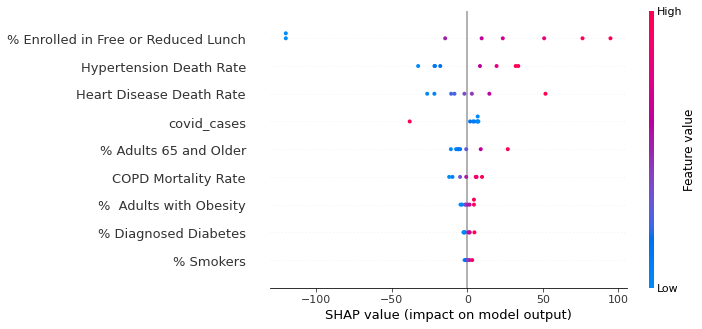

In [187]:
shap.summary_plot(shap_values, x_o2, feature_names=X_train_o2.columns)